# Web Scraping

I'll be going over the tools you have at your disposal to scrape the world wide web using Python. This will be organized into three sections, each for a slightly different use case. I recommend beginning with the first one and escalating if it doesn't suit your needs.

## Don't Bring a Knife to a Gun Fight: Chrome Dev Tools

https://housing.illinois.edu/Dining/Menus/Dining-Halls

This is the easiest option, and one that you should only use if you're doing an ad hoc job of maybe just scraping a single table from a single page. You can also use dev tools to help you debug and write the code for the next two sections.

I'll also be using this section to explain some basic web concepts that will be useful to know.

### HTML

Webpage content is written in HTML. HTML follows a tree structure. Tags can contain other tags: each tag can have only one parent but multiple children. A tag is something that looks like `<div></div>` or `<p></p>` or `<a></a>`, etc.

`<div>` is an opening tag and `</div>` is a closing tag. Any children go in between. For example,

```html
<div id="text">
    <p class="red">Hello world</p>
    <p class="red" color="blue">Click this <a href="https://google.com">link</a></p>
</div>
```

How many children does the `<div>` have? How many children does each `<p>` have?

### CSS Selectors

To style websites, we use CSS (Cascading Style Sheets). For the browser to know which HTML elements (tags) receive which styles, elements have CSS selectors. It's kind of a like a querying language to find the elements you're interested in.

Consider again:

```html
<div id="text">
    <p class="red">Hello world</p>
    <p class="red" color="blue">Click this <a href="https://google.com">link</a></p>
</div>
```

We can select **by ID** with: `#` (e.g. `#text`)

We can select **by class** with: `.` (e.g. `.red`)

We can select by **arbitrary attributes** with: `[attr=]` (e.g. `[color=blue]`)

We can select by **element type** with just the element (e.g. `div`)

### Using Dev Tools to Get Elements

Dev Tools opens a JavaScript console, which we can use to query for elements using CSS selectors.

Navigate to: https://housing.illinois.edu/Dining/Menus/Dining-Halls

Press CMD+SHIFT+I or CTRL+SHIFT+I to launch dev tools (alternatively, right click and select "Inspect Element"). Your screen might look something like this:

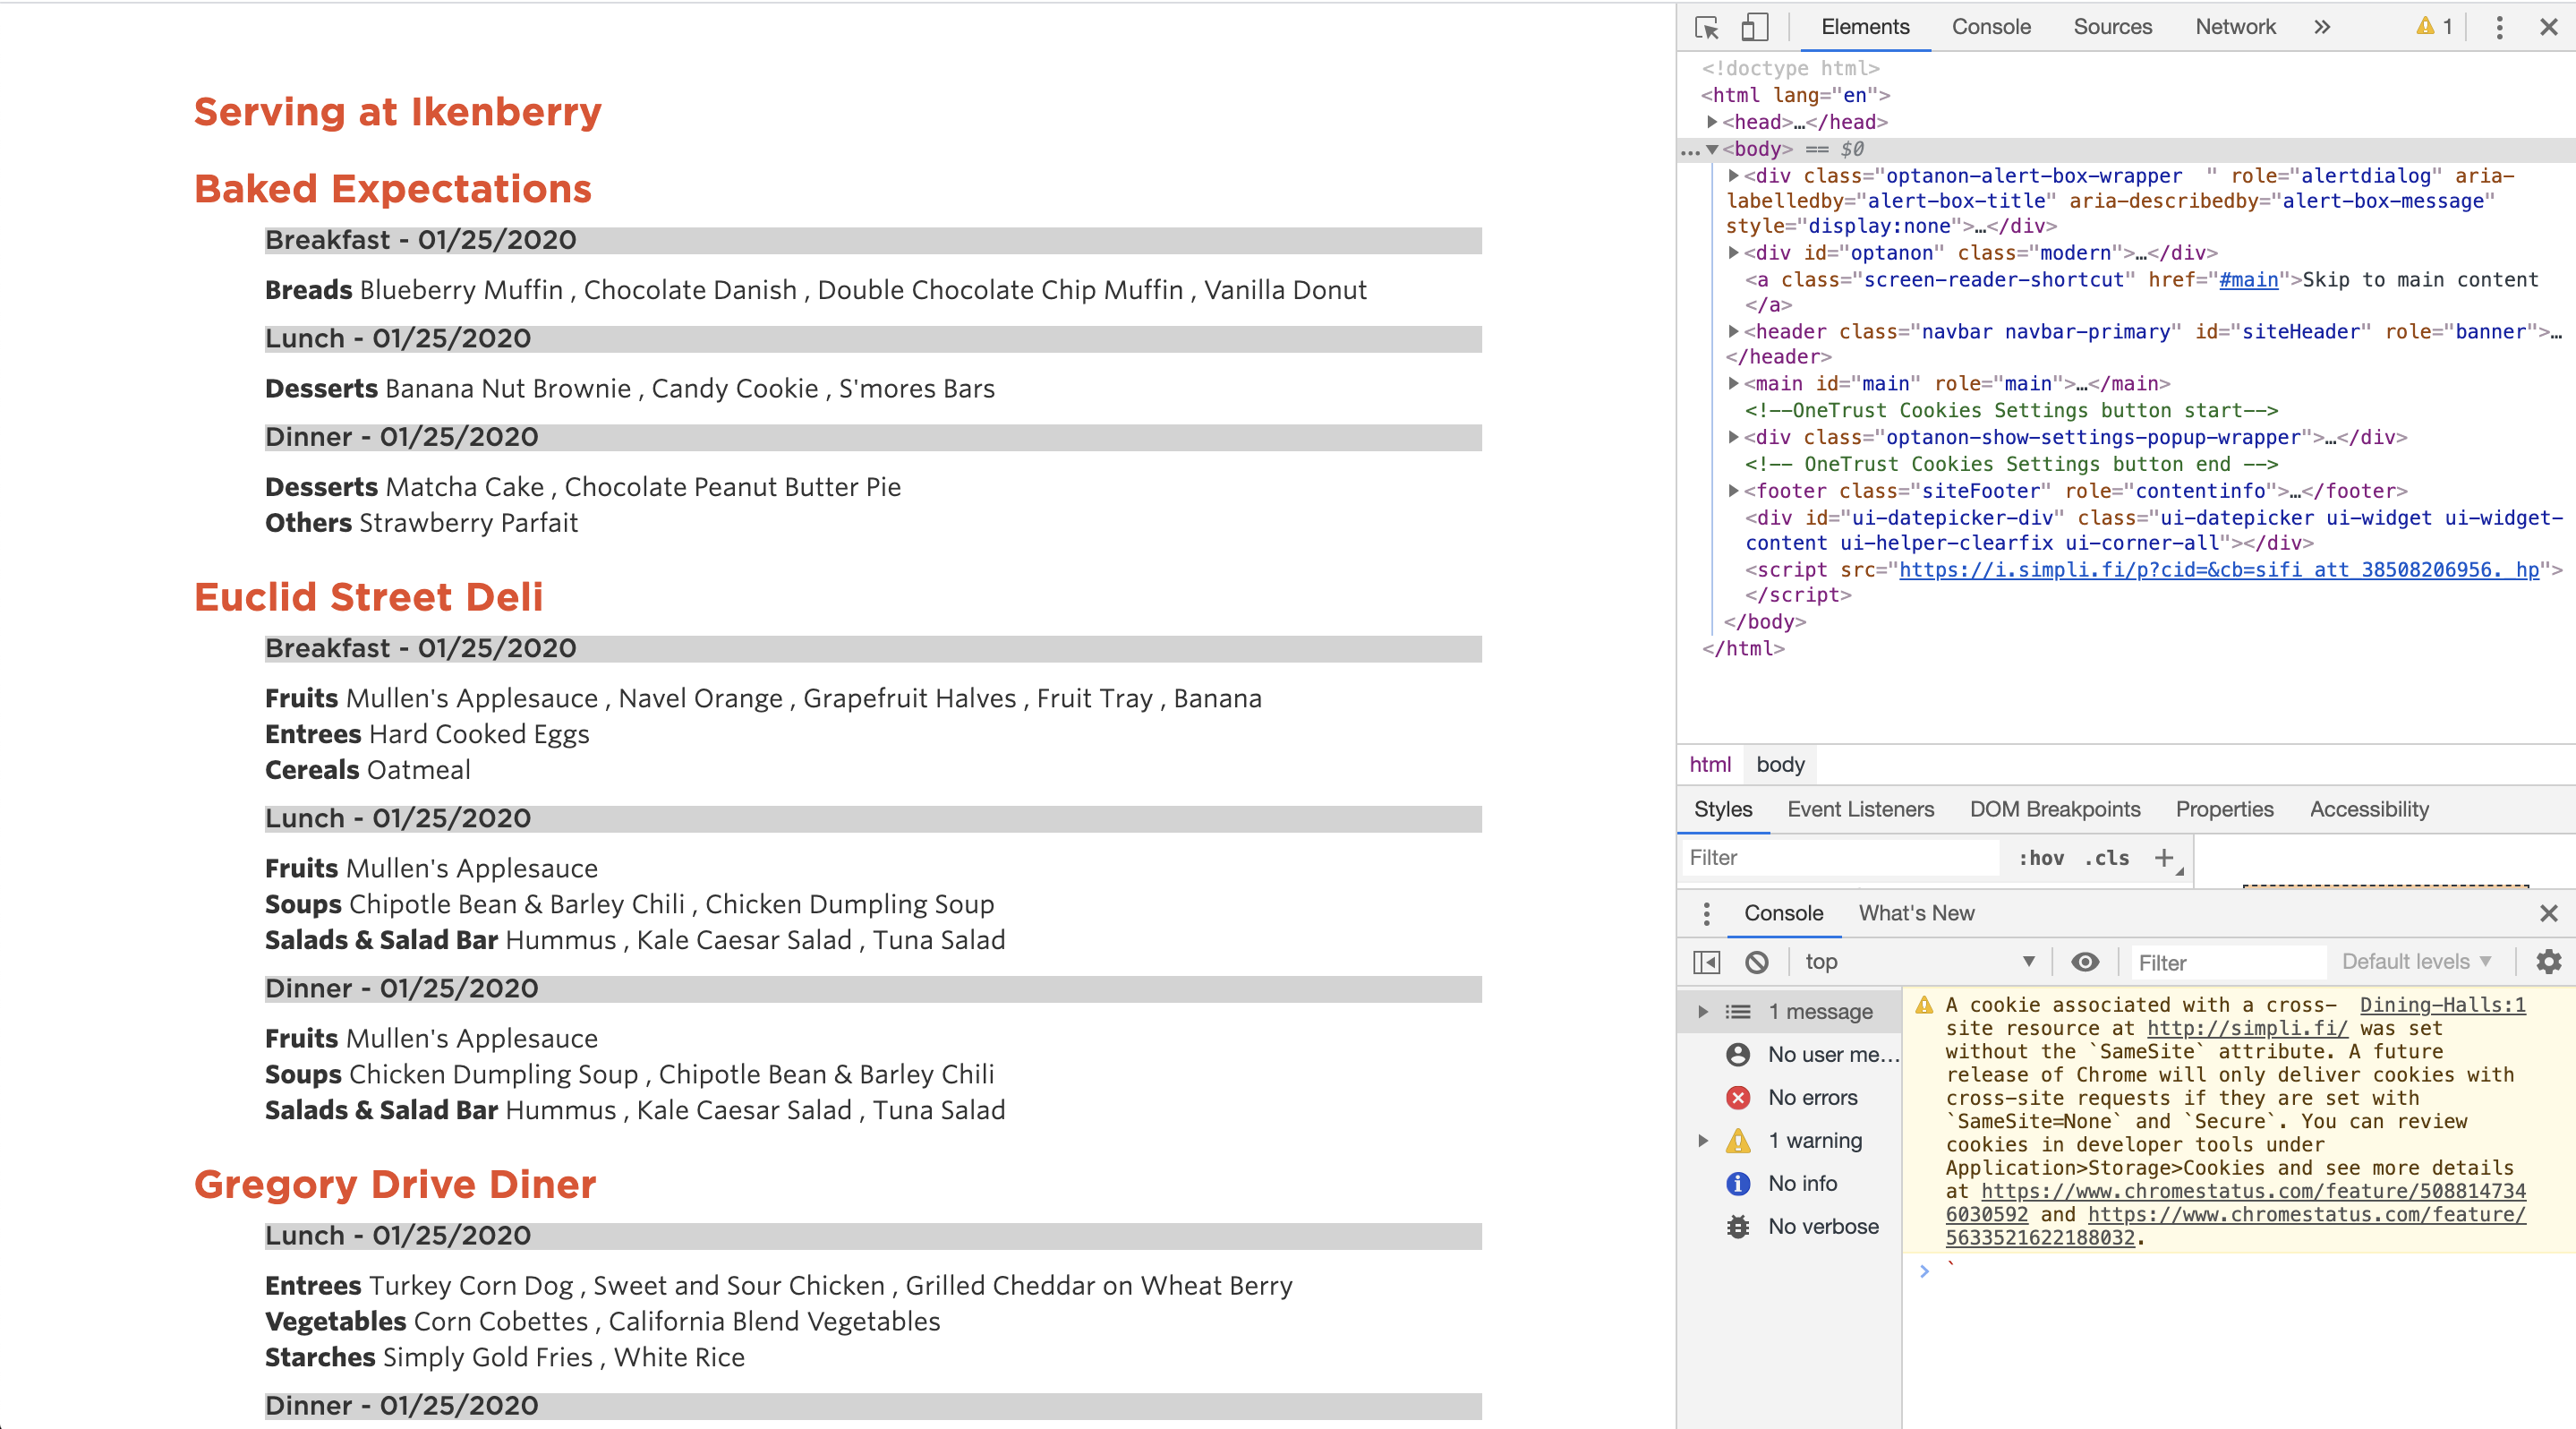

## The Ol' Reliable: BeautifulSoup4 and Requests

In [1]:
from bs4 import BeautifulSoup
import requests
import time
from tqdm import tqdm_notebook as tqdm

In [2]:
r = requests.get("https://offcampushousing.umich.edu/property/search?view=grid&sort=default&per_bed=u&r%5Bmin%5D=&r%5Bmax%5D=&page=1&search_all=&movein-start=0&movein-end=1&o=&distance%5B132%5D=&distance%5B133%5D=&text_search=")

In [3]:
soup = BeautifulSoup(r.text, "html.parser")

In [12]:
links = []
for i in range(1, 35):
    r = requests.get("https://offcampushousing.umich.edu/property/search?view=grid&sort=default&per_bed=u&r%5Bmin%5D=&r%5Bmax%5D=&page={}&search_all=&movein-start=0&movein-end=1&o=&distance%5B132%5D=&distance%5B133%5D=&text_search=".format(i))
    soup = BeautifulSoup(r.text, "html.parser")
    if i % 3 == 0:
        print("visiting items starting on page {}".format(i))
    for result in soup.select('div.listing-name > h2'):
        links.append("https://www.showmetherent.com" + result.a.get("href"))

visiting items starting with 0
visiting items starting with 40
visiting items starting with 80
visiting items starting with 120
visiting items starting with 160
visiting items starting with 200
visiting items starting with 240
visiting items starting with 280
visiting items starting with 320
visiting items starting with 360
visiting items starting with 400
visiting items starting with 440
visiting items starting with 480
visiting items starting with 520
visiting items starting with 560
visiting items starting with 600
visiting items starting with 640
visiting items starting with 680
visiting items starting with 720
visiting items starting with 760
visiting items starting with 800


In [13]:
print(len(links))
print(links[0]) 
print(links[1])

810
https://www.showmetherent.com/544-N-State-St-Ann-Arbor-MI-48104
https://www.showmetherent.com/536-S-Forest-Ave-Ann-Arbor-MI-48104


In [145]:
listings = {
    "updated_datetime": [], 
    "address": [], 
    "company": [], 
    "property_type": [], 
    "year_built": [],
    "price": [],
    "name": [],
    "deposit": [],
    "bed": [],
    "bath": [],
    "area": [],
    "description": [],
    "images": []
}

for link in tqdm(links):
    r = requests.get(link)
    s = BeautifulSoup(r.text, "html.parser")
    
    try:
        description = s.select('div.description')[0].text.strip()
        listings['description'].append(description)
    
    except:
        print('[description] exception')
    
    try:
        updated = s.select('div#propertydetail-lastupdated')[0].text.strip()
        listings['updated_datetime'].append(updated[8:]) 
        
    except: 
        print('[updated_datetime] exception')
        
    try:
        year_flag, company_flag = False, False
        for p in s.select('div.details > p'):
            if p.select('span')[0].text.strip() == 'Address:':
                address = p.contents[2].strip()
                listings['address'].append(address)
            elif p.select('span')[0].text.strip() == 'Managed by:':
                company = p.contents[3].text
                listings['company'].append(company)
                company_flag = True
            elif p.select('span')[0].text.strip() == 'Property Type:':
                types = p.contents[2].strip()
                listings['property_type'].append(types)
            elif p.select('span')[0].text.strip() == 'Year Built:':
                year_built = p.contents[2].strip()
                listings['year_built'].append(float(year_built))
                year_flag = True
            
        if not year_flag:
            listings['year_built'].append(None)
        if not company_flag:
            listings['company'].append(None)
        
    except:
        print('[overall details] exception')
        
    
    price, name, deposit, bed, bath, area, images = [], [], [], [], [], [], []
    for unit in s.select('div.unit-list-detail'):
        try:
            price_ = unit.select('div.property-unit-header > h2 > span.property-unit-rent')[0].text.strip()
            name_ = unit.select('div.property-unit-header > h2 > span.property-unit-title')[0].text.strip()
            price.append(price_)
            name.append(name_)
            
        except:
            print('[name, price] exception')
            
        try:
            deposit_ = s.select('p.property-unit-deposit')[0].text.strip()
            deposit.append(deposit_)
            
            details = s.select('p.property-unit-details')[0].text.split('\n')
            bed_, bath_, area_ = details[1].strip(), details[2].strip(), details[3].strip()
            bed.append(bed_)
            bath.append(bath_)
            area.append(area_)
            
        except:
            print('something went wrong :/')
            
        try:
            img_unit = []
            img = s.select('div#unitpic_0 > a.unitpiczoom > img')[0].get('src')
            img_unit.append(img)
            
            imgs = s.select('div#unitpic_0 > a.hidden > img')
            for pic in imgs:
                img_unit.append(pic.get('src'))
            
        except:
            img_unit = []
            
        images.append(img_unit)
        
    listings['images'].append(images)
    listings['price'].append(price)
    listings['name'].append(name)
    listings['deposit'].append(deposit)
    listings['bed'].append(bed)
    listings['bath'].append(bath)
    listings['area'].append(area)

In [146]:
for d in listings.items():
    print(d[0], len(d[1]))

updated_datetime 810
address 810
company 810
property_type 810
year_built 810
price 810
name 810
deposit 810
bed 810
bath 810
area 810
description 810
images 810


In [147]:
import json
with open('showmetherent.json', 'w') as f:
    json.dump(listings, f)